In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import wandb
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)

from models.cnn.cnn import CNNModel
from models.cnn.multilabel_cnn import MultiLabelCNN

from performance_measures.metrics import Metrics
from models.MLP.MLP import MLP_Classifier
from performance_measures import metrics as metrics1
from models.MLP.MLP import MLP_Regression
from models.AutoEncoders.AutoEncoders import AutoEncoder
from models.knn.knn import KNN


In [9]:
def load_mnist_data(root_dir):
    data = {'train': [], 'val': [], 'test': []}
    
    # Loop over the splits (train, val, test)
    for split in data.keys():
        split_dir = os.path.join(root_dir, split)
        
        # Loop over each folder in the split directory (e.g., "0", "1", "12", etc.)
        for label_folder in os.listdir(split_dir):
            label_dir = os.path.join(split_dir, label_folder)
            
            # Only process if it's a directory
            if not os.path.isdir(label_dir):
                continue
            
            # Use the folder name as the label (this can be multi-digit, e.g., "12")
            label = [int(digit) for digit in label_folder]  # Convert each character to int
            
            # Loop over each image file in the label folder
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode
                if image is not None:
                    data[split].append((image, label))
    
    return data

def one_hot_encode(labels, num_classes):
    # Create a one-hot encoded representation of the labels
    one_hot_labels = []
    for label in labels:
        one_hot = np.zeros(num_classes)  # Create a zero vector of length num_classes
        for digit in label:
            one_hot[digit] = 1  # Set indices corresponding to the digits to 1
        one_hot_labels.append(one_hot)
    return np.array(one_hot_labels)

# Path to the dataset
dir_path1 = '../../data/interim/4/double_mnist'
data = load_mnist_data(dir_path1)

# Check the loaded data structure
print(f"Number of training samples: {len(data['train'])}")
print(f"Number of validation samples: {len(data['val'])}")
print(f"Number of test samples: {len(data['test'])}")


# One-Hot Encode the labels (assuming digits 0-9)
num_classes = 10  # For digits 0-9
one_hot_labels_train = one_hot_encode([label for _, label in data['train']], num_classes)
one_hot_labels_val = one_hot_encode([label for _, label in data['val']], num_classes)
one_hot_labels_test = one_hot_encode([label for _, label in data['test']], num_classes)

# Update MultiMNISTDataset class to return one-hot encoded labels
class MultiMNISTDataset(Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get the image and label at index `idx`
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert the image to a format compatible with PyTorch transformations
        image = np.expand_dims(image, axis=2)  # Add channel dimension for grayscale
        image = transforms.ToTensor()(image)  # Convert to Tensor
        
        # Apply transformations, if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transform = transforms.Normalize((0.5,), (0.5,))  # Normalization for grayscale

# Create Dataset and DataLoader instances for each split
train_dataset = MultiMNISTDataset([img for img, _ in data['train']], one_hot_labels_train, transform=transform)
val_dataset = MultiMNISTDataset([img for img, _ in data['val']], one_hot_labels_val, transform=transform)
test_dataset = MultiMNISTDataset([img for img, _ in data['test']], one_hot_labels_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check sample batch
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels (one-hot encoded): {labels}")
    break

# Check the unique labels
unique_labels = set(tuple(label) for _, label in data['train'])  # Extract unique labels from the training data
print(f"Number of unique labels: {len(unique_labels)}, Unique labels: {unique_labels}")


Number of training samples: 12600
Number of validation samples: 3000
Number of test samples: 4600
Batch of images shape: torch.Size([32, 1, 128, 128])
Batch of labels (one-hot encoded): tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [1., 0

## 3.2

Yes, this model requires an additional activation function after the last linear layer, unlike the previous CNN classifier. Because it is multi class classification we need to get values at last leayer which account for other classes as well. That is wee need kind of last layer each neuron corresponding to a specific class to be normalized or scaled so that it is possible to comapare between various classes. Sigmoid activation function is a good choice for this. because it gives output between 0 to 1 and high value corresponding high output(near 1) and low values corresponding low output(near 0). Also neuron can have any real number as its value so this activation function covers the entire range of real numbers. Due to all these properties it enable comparison between various classes. 

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss

class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(MultiLabelCNN, self).__init__()
        
        # First Convolutional Block
        # Input: 128x128 -> Output: 64x64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        
        # Second Convolutional Block
        # Input: 64x64 -> Output: 32x32
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        
        # Third Convolutional Block
        # Input: 32x32 -> Output: 16x16
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        
        # Fourth Convolutional Block
        # Input: 16x16 -> Output: 8x8
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )
        
        # Fully connected layers
        # After conv4: 256 * 8 * 8 = 16384 features
        self.fc = nn.Sequential(
            nn.Linear(16384, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)  # Flatten: 256 * 8 * 8 = 16384
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels.float())
                running_val_loss += val_loss.item()
                
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}')
        
        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break
    
    return train_losses, val_losses

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Threshold at 0.5
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    exact_match = np.mean(np.all(all_preds == all_labels, axis=1))
    hamming_acc = 1 - hamming_loss(all_labels, all_preds)
    
    return exact_match, hamming_acc

# Hyperparameter configurations
hyperparameter_configs = [
    {'lr': 0.01, 'dropout': 0.3, 'batch_size': 32, 'optimizer': 'adam'},
    {'lr': 0.001, 'dropout': 0.5, 'batch_size': 64, 'optimizer': 'sgd'},
    {'lr': 0.01, 'dropout': 0.4, 'batch_size': 32, 'optimizer': 'sgd'},
    {'lr': 0.0005, 'dropout': 0.5, 'batch_size': 32, 'optimizer': 'adam'},
    {'lr': 0.001, 'dropout': 0.5, 'batch_size': 16, 'optimizer': 'adam'},
]

# Training and evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

results = []
train_losses_list = []
val_losses_list = []

for i, config in enumerate(hyperparameter_configs):
    print(f"\nTraining with config {i+1}/{len(hyperparameter_configs)}: {config}")
    
    # Create model with current dropout rate
    model = MultiLabelCNN(dropout_rate=config['dropout']).to(device)
    
    # Create optimizer
    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)
    
    criterion = nn.BCELoss()
    
    # Train model
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, 
                                         optimizer, num_epochs=4, device=device)
    
    # Evaluate model
    train_exact, train_hamming = evaluate_model(model, train_loader, device)
    val_exact, val_hamming = evaluate_model(model, val_loader, device)
    test_exact, test_hamming = evaluate_model(model, test_loader, device)
    
    results.append({
        'config': config,
        'metrics': {
            'train': {'exact': train_exact, 'hamming': train_hamming},
            'val': {'exact': val_exact, 'hamming': val_hamming},
            'test': {'exact': test_exact, 'hamming': test_hamming}
        }
    })
    
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)

# Find best model based on validation exact match accuracy
best_model_idx = np.argmax([result['metrics']['val']['exact'] for result in results])
best_config = results[best_model_idx]['config']
best_metrics = results[best_model_idx]['metrics']

print("\nBest Model Configuration:")
print(f"Learning Rate: {best_config['lr']}")
print(f"Dropout Rate: {best_config['dropout']}")
print(f"Batch Size: {best_config['batch_size']}")
print(f"Optimizer: {best_config['optimizer']}")

print("\nBest Model Performance:")
print("Train - Exact Match: {:.4f}, Hamming Accuracy: {:.4f}".format(
    best_metrics['train']['exact'], best_metrics['train']['hamming']))
print("Val - Exact Match: {:.4f}, Hamming Accuracy: {:.4f}".format(
    best_metrics['val']['exact'], best_metrics['val']['hamming']))
print("Test - Exact Match: {:.4f}, Hamming Accuracy: {:.4f}".format(
    best_metrics['test']['exact'], best_metrics['test']['hamming']))

Using device: cpu

Training with config 1/5: {'lr': 0.01, 'dropout': 0.3, 'batch_size': 32, 'optimizer': 'adam'}
Epoch [1/4] - Train Loss: 18.8877, Val Loss: 19.2088
Epoch [2/4] - Train Loss: 18.9324, Val Loss: 19.2088
Epoch [3/4] - Train Loss: 18.9314, Val Loss: 19.2088
Epoch [4/4] - Train Loss: 18.9314, Val Loss: 19.2088

Training with config 2/5: {'lr': 0.001, 'dropout': 0.5, 'batch_size': 64, 'optimizer': 'sgd'}
Epoch [1/4] - Train Loss: 0.5189, Val Loss: 0.5366
Epoch [2/4] - Train Loss: 0.4814, Val Loss: 0.4845
Epoch [3/4] - Train Loss: 0.4754, Val Loss: 0.4975
Epoch [4/4] - Train Loss: 0.4713, Val Loss: 0.5254

Training with config 3/5: {'lr': 0.01, 'dropout': 0.4, 'batch_size': 32, 'optimizer': 'sgd'}
Epoch [1/4] - Train Loss: 0.4770, Val Loss: 0.7280
Epoch [2/4] - Train Loss: 0.4545, Val Loss: 1.0169
Epoch [3/4] - Train Loss: 0.4471, Val Loss: 1.1390
Epoch [4/4] - Train Loss: 0.4378, Val Loss: 1.0854

Training with config 4/5: {'lr': 0.0005, 'dropout': 0.5, 'batch_size': 32, 'o

### Hyperparameter Tuning  

Training with config 1/5: {'lr': 0.01, 'dropout': 0.3, 'batch_size': 32, 'optimizer': 'adam'}
Epoch [1/4] - Train Loss: 18.8877, Val Loss: 19.2088
Epoch [2/4] - Train Loss: 18.9324, Val Loss: 19.2088
Epoch [3/4] - Train Loss: 18.9314, Val Loss: 19.2088
Epoch [4/4] - Train Loss: 18.9314, Val Loss: 19.2088

Training with config 2/5: {'lr': 0.001, 'dropout': 0.5, 'batch_size': 64, 'optimizer': 'sgd'}
Epoch [1/4] - Train Loss: 0.5189, Val Loss: 0.5366
Epoch [2/4] - Train Loss: 0.4814, Val Loss: 0.4845
Epoch [3/4] - Train Loss: 0.4754, Val Loss: 0.4975
Epoch [4/4] - Train Loss: 0.4713, Val Loss: 0.5254

Training with config 3/5: {'lr': 0.01, 'dropout': 0.4, 'batch_size': 32, 'optimizer': 'sgd'}
Epoch [1/4] - Train Loss: 0.4770, Val Loss: 0.7280
Epoch [2/4] - Train Loss: 0.4545, Val Loss: 1.0169
Epoch [3/4] - Train Loss: 0.4471, Val Loss: 1.1390
Epoch [4/4] - Train Loss: 0.4378, Val Loss: 1.0854

Training with config 4/5: {'lr': 0.0005, 'dropout': 0.5, 'batch_size': 32, 'optimizer': 'adam'}
Epoch [1/4] - Train Loss: 0.4852, Val Loss: 0.7935
Epoch [2/4] - Train Loss: 0.4629, Val Loss: 0.7281
Epoch [3/4] - Train Loss: 0.4557, Val Loss: 0.5670
Epoch [4/4] - Train Loss: 0.4269, Val Loss: 0.4659

Training with config 5/5: {'lr': 0.001, 'dropout': 0.5, 'batch_size': 16, 'optimizer': 'adam'}
Epoch [1/4] - Train Loss: 0.4939, Val Loss: 0.6617
Epoch [2/4] - Train Loss: 0.4690, Val Loss: 0.5531
Epoch [3/4] - Train Loss: 0.4619, Val Loss: 0.6495
Epoch [4/4] - Train Loss: 0.4374, Val Loss: 0.7216

Best Model Configuration:
Learning Rate: 0.0005
Dropout Rate: 0.5
Batch Size: 32
Optimizer: adam

Best Model Performance:
Train - Exact Match: 0.0866, Hamming Accuracy: 0.8295
Val - Exact Match: 0.0373, Hamming Accuracy: 0.8118
Test - Exact Match: 0.0250, Hamming Accuracy: 0.8260






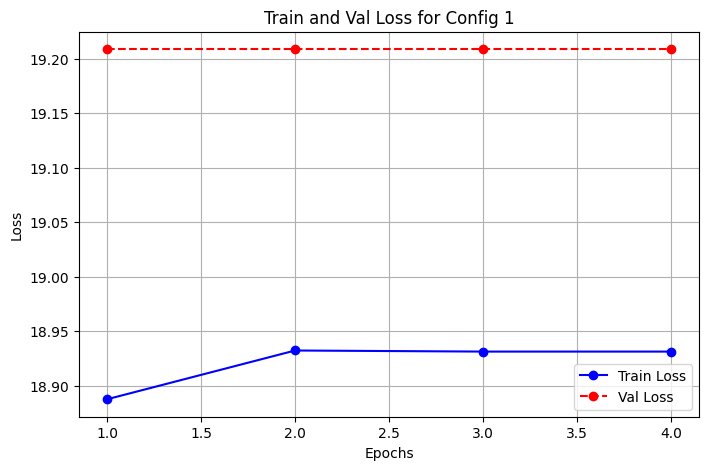

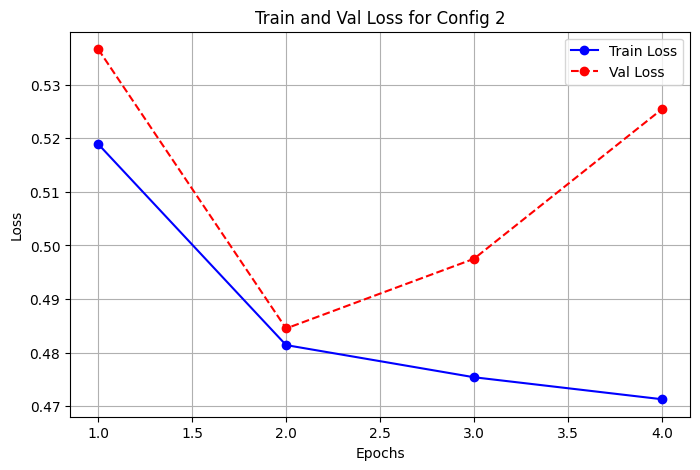

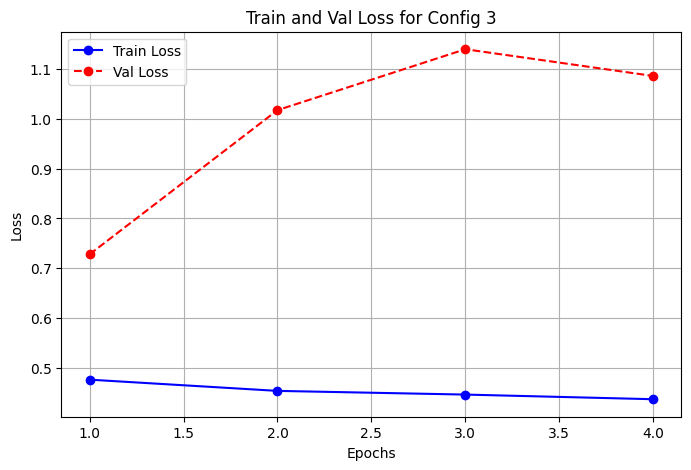

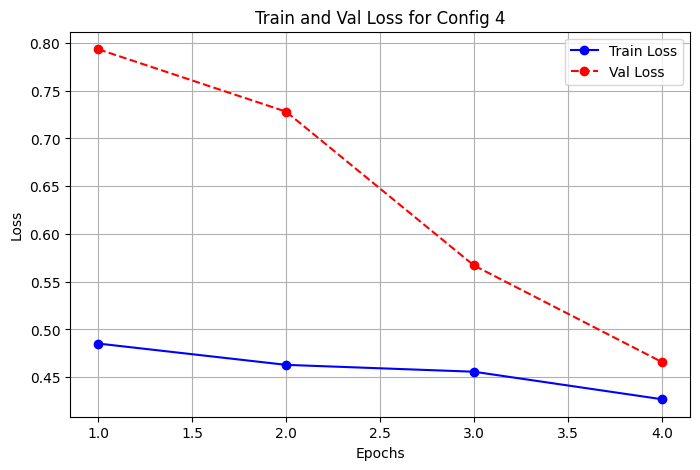

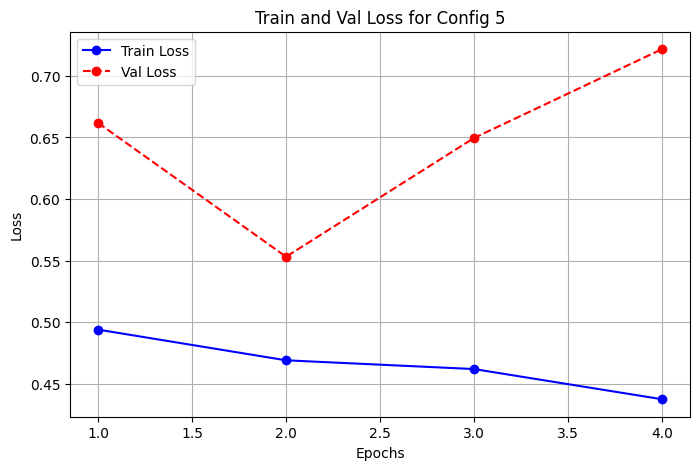

In [20]:
# Define the train and validation losses for each configuration
train_losses = {
    'Config 1': [18.8877, 18.9324, 18.9314, 18.9314],
    'Config 2': [0.5189, 0.4814, 0.4754, 0.4713],
    'Config 3': [0.4770, 0.4545, 0.4471, 0.4378],
    'Config 4': [0.4852, 0.4629, 0.4557, 0.4269],
    'Config 5': [0.4939, 0.4690, 0.4619, 0.4374]
}

val_losses = {
    'Config 1': [19.2088, 19.2088, 19.2088, 19.2088],
    'Config 2': [0.5366, 0.4845, 0.4975, 0.5254],
    'Config 3': [0.7280, 1.0169, 1.1390, 1.0854],
    'Config 4': [0.7935, 0.7281, 0.5670, 0.4659],
    'Config 5': [0.6617, 0.5531, 0.6495, 0.7216]
}

# Plotting each configuration separately
for i, config in enumerate(train_losses.keys(), 1):
    plt.figure(figsize=(8, 5))
    epochs = range(1, 5)  # 4 epochs

    # Plot train and validation loss for the current configuration
    plt.plot(epochs, train_losses[config], marker='o', linestyle='-', color='b', label='Train Loss')
    plt.plot(epochs, val_losses[config], marker='o', linestyle='--', color='r', label='Val Loss')

    # Labels, title, and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train and Val Loss for {config}')
    plt.legend()
    plt.grid(True)

    plt.savefig("figures/multilabel_hyperparameter_"+str(i))
    plt.show()


### Analysis based on above plots:

First plot has very high losses as comapared to all other. This indicates that in case of adam optimizer high lerning rate(0.01 here) leads to non updating high losses. Plots 2, 3 show that in case of sgd optmizer val loss is decreasing with epochs as expected. But train loss shows anomalous behavious sometimes increasing and some times decreasing or constant. Plot 4 has ideal always decreasing train and val losses. This supports the first observation that is low learning rate (here 0.0005) causes adam optmizer to give good results i.e decreasing losses. Plot 5 suggests that moderate learning rate mya cause fluctuations in losses for adam optmizer.    

At the end we get best model to be model 4 which matches our observations based on plots. 